# Create an electoral map of the UK from the 2024 general election results


This task will require using the HOC API in a couple of steps: 

1. Create a dataset of each constituency in 2024 
2. Use constituency IDs to find the electoral results for each constituency in 2024 
3. Use the constituency IDs to find the geometry (e.g. boundaries) of each constituency to plot the results on a map
4. Clean the data and prepare it for visualization
5. Create a map of the results using the `geopandas` library 


We'll use the `Members` API for the steps 1-3. 


Members API: [https://members-api.parliament.uk/index.html](https://members-api.parliament.uk/index.html)


## We'll use the following libraries:
```python
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
```

In [96]:
pip install pandas requests matplotlib seaborn geopandas tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [163]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from shapely.geometry import shape
import json

# Step 1: Create a dataset of each constituency in 2024

**Note** we need to get the list of constituencies and their IDs to query the results later

In [10]:
# task 1: create a dataset of all the constituencies in the UK


# function to get the endpoint for constituencies
def get_constituency_endpoint(skip=0, take=20):
    return f"https://members-api.parliament.uk/api/Location/Constituency/Search?skip={skip}&take={take}"



# function to collect constituencies data
def collect_constituencies_data(): 
    constituencies = []
    skip = 0
    while True:
        response = requests.get(get_constituency_endpoint(skip))
        if response.status_code != 200:
            print(f"Error fetching data: {response.status_code}")
            break
        data = response.json()
        constituencies.extend(data['items'])
        if len(data['items']) < 20:  # If less than take, we reached the end
            print("No more constituencies to fetch.")
            break
        skip += 20
    return pd.DataFrame(constituencies)





# collect constituencies data
con_df = collect_constituencies_data()


No more constituencies to fetch.


In [19]:
# create columns for each key in the 'value' column
con_df_expanded = con_df.join(pd.json_normalize(con_df['value']))
con_df_expanded

value  \
0    {'id': 4496, 'name': 'Aberafan Maesteg', 'star...   
1    {'id': 4449, 'name': 'Aberdeen North', 'startD...   
2    {'id': 4450, 'name': 'Aberdeen South', 'startD...   
3    {'id': 4451, 'name': 'Aberdeenshire North and ...   
4    {'id': 4452, 'name': 'Airdrie and Shotts', 'st...   
..                                                 ...   
645  {'id': 4417, 'name': 'Wythenshawe and Sale Eas...   
646  {'id': 4418, 'name': 'Yeovil', 'startDate': '2...   
647  {'id': 4527, 'name': 'Ynys Môn', 'startDate': ...   
648  {'id': 4419, 'name': 'York Central', 'startDat...   
649  {'id': 4420, 'name': 'York Outer', 'startDate'...   

                                                 links    id  \
0    [{'rel': 'self', 'href': '/Constituency/4496/A...  4496   
1    [{'rel': 'self', 'href': '/Constituency/4449/A...  4449   
2    [{'rel': 'self', 'href': '/Constituency/4450/A...  4450   
3    [{'rel': 'self', 'href': '/Constituency/4451/A...  4451   
4    [{'rel': 'self', 'href': '/Constituency/4452/A...  4452   
..                                                 ...   ...   
645  [{'rel': 'self', 'href': '/Constituency/4417/W...  4417   
646  [{'rel': 'self', 'href': '/Constituency/4418/Y...  4418   
647  [{'rel': 'self', 'href': '/Constituency/4527/Y...  4527   
648  [{'rel': 'self', 'href': '/Constituency/4419/Y...  4419   
649  [{'rel': 'self', 'href': '/Constituency/4420/Y...  4420   

                                   name            startDate endDate  \
0                      Aberafan Maesteg  2024-05-31T00:00:00    None   
1                        Aberdeen North  2024-05-31T00:00:00    None   
2                        Aberdeen South  2024-05-31T00:00:00    None   
3    Aberdeenshire North and Moray East  2024-05-31T00:00:00    None   
4                    Airdrie and Shotts  2024-05-31T00:00:00    None   
..                                  ...                  ...     ...   
645           Wythenshawe and Sale East  2024-05-31T00:00:00    None   
646                              Yeovil  2024-05-31T00:00:00    None   
647                            Ynys Môn  2024-05-31T00:00:00    None   
648                        York Central  2024-05-31T00:00:00    None   
649                          York Outer  2024-05-31T00:00:00    None   

     currentRepresentation.member.value.id  \
0                                     4359   
1                                     4357   
2                                     4735   
3                                     5280   
4                                     5200   
..                                     ...   
645                                   4316   
646                                   5191   
647                                   5085   
648                                   4471   
649                                   5199   

    currentRepresentation.member.value.nameListAs  \
0                                Kinnock, Stephen   
1                                Blackman, Kirsty   
2                                  Flynn, Stephen   
3                                   Logan, Seamus   
4                              Stevenson, Kenneth   
..                                            ...   
645                                    Kane, Mike   
646                                   Dance, Adam   
647                                  Medi, Llinos   
648                              Maskell, Rachael   
649                             Charters, Mr Luke   

    currentRepresentation.member.value.nameDisplayAs  \
0                                    Stephen Kinnock   
1                                    Kirsty Blackman   
2                                      Stephen Flynn   
3                                       Seamus Logan   
4                                  Kenneth Stevenson   
..                                               ...   
645                                        Mike Kane   
646                                       Adam Dance   
647                     

In [21]:
# check to make sure that we have 650 constituencies
con_df_expanded['id'].nunique() == 650

True

In [ ]:
# optional: save the dataframe to a CSV file
con_df_expanded.to_csv('data/UK_constituencies_2024.csv', index=False)

# Step 2: Get the results for each constituency in 2024


The endpoint for the results takes a constituency ID and returns the results for that constituency

[https://members-api.parliament.uk/api/Location/Constituency/CONSTITUENCY_ID/ElectionResults](https://members-api.parliament.uk/api/Location/Constituency/CONSTITUENCY_ID/ElectionResults), where `CONSTITUENCY_ID` is the ID of the constituency you want to query.

In [108]:
import time # we'll use this to avoid hitting the API too hard

# create an function for the endpoint for electoral data for a given constituency
def create_endpoint_for_electoral_data(constituency_id):
    return f"https://members-api.parliament.uk/api/Location/Constituency/{constituency_id}/ElectionResults"

# function to collect electoral data for a given constituency
def collect_electoral_data(constituency_id):
    endpoint = create_endpoint_for_electoral_data(constituency_id)
    response = requests.get(endpoint)
    if response.status_code != 200:
        print(f"Error fetching data for {constituency_id}: {response.status_code}")
        return None
    data = response.json()
    # normalize the data to a DataFrame
    data_normalized = pd.json_normalize(data['value'])
    # add in the constituency ID for reference
    data_normalized['constituency_id'] = constituency_id
    return data_normalized


In [109]:
# test on a single constituency 

con_id = 4418  # Example constituency ID from df above 
collect_electoral_data(con_id)

result  isNotional  electorate  turnout  majority          electionTitle  \
0  LD Gain       False       79918    48952     12268  2024 General Election   

          electionDate  electionId  isGeneralElection constituencyName  ...  \
0  2024-07-04T00:00:00         422               True           Yeovil  ...   

  winningParty.id  winningParty.name winningParty.abbreviation  \
0              17   Liberal Democrat                        LD   

  winningParty.backgroundColour winningParty.foregroundColour  \
0                        faa01a                        FFFFFF   

  winningParty.isLordsMainParty  winningParty.isLordsSpiritualParty  \
0                          True                               False   

   winningParty.governmentType winningParty.isIndependentParty  \
0                         None                           False   

   constituency_id  
0             4418  

[1 rows x 21 columns]

In [110]:



# loop through all constituencies and collect electoral data
# why is it better to hard code the loop instead of writing a function?



electoral_data = pd.DataFrame()  # to store all electoral data
for con_id in tqdm(con_df_expanded['id']): # use tqdm to show progress
    data = collect_electoral_data(con_id)
    if data is not None:
        electoral_data = pd.concat([electoral_data, data], ignore_index=True)
    else:
        print(f"No data found for constituency ID: {con_id}")
        pass 
    time.sleep(.3)  # sleep to avoid hitting the API too hard
    
    

    

100%|██████████| 650/650 [01:16<00:00,  8.46it/s]


In [111]:
# do we notice any issues with the data?
electoral_data

result  isNotional  electorate  turnout  majority  \
0    Lab Hold       False       72580    35755     10354   
1    SNP Hold       False       75925    42095      1760   
2    SNP Hold       False       77328    46345      3758   
3    SNP Gain       False       70058    38188       942   
4    Lab Gain       False       70199    36666      7547   
..        ...         ...         ...      ...       ...   
646  Lab Hold       False       77767    39132     14610   
647   LD Gain       False       79918    48952     12268   
648   PC Gain       False       53141    32628       637   
649  Lab Hold       False       79557    43323     19154   
650  Lab Gain       False       76228    51106      9391   

             electionTitle         electionDate  electionId  \
0    2024 General Election  2024-07-04T00:00:00         422   
1    2024 General Election  2024-07-04T00:00:00         422   
2    2024 General Election  2024-07-04T00:00:00         422   
3    2024 General Election  2024-07-04T00:00:00         422   
4    2024 General Election  2024-07-04T00:00:00         422   
..                     ...                  ...         ...   
646  2024 General Election  2024-07-04T00:00:00         422   
647  2024 General Election  2024-07-04T00:00:00         422   
648  2024 General Election  2024-07-04T00:00:00         422   
649  2024 General Election  2024-07-04T00:00:00         422   
650  2024 General Election  2024-07-04T00:00:00         422   

     isGeneralElection                    constituencyName  ...  \
0                 True                    Aberafan Maesteg  ...   
1                 True                      Aberdeen North  ...   
2                 True                      Aberdeen South  ...   
3                 True  Aberdeenshire North and Moray East  ...   
4                 True                  Airdrie and Shotts  ...   
..                 ...                                 ...  ...   
646               True           Wythenshawe and Sale East  ...   
647               True                              Yeovil  ...   
648               True                            Ynys Môn  ...   
649               True                        York Central  ...   
650               True                          York Outer  ...   

    winningParty.id        winningParty.name winningParty.abbreviation  \
0                15                   Labour                       Lab   
1                29  Scottish National Party                       SNP   
2                29  Scottish National Party                       SNP   
3                29  Scottish National Party                       SNP   
4                15                   Labour                       Lab   
..              ...                      ...                       ...   
646              15                   Labour                       Lab   
647              17         Liberal Democrat                        LD   
648              22              Plaid Cymru                        PC   
649              15                   Labour                       Lab   
650              15                   Labour                       Lab   

    winningParty.backgroundColour winningParty.foregroundColour  \
0                          d50000                        ffffff   
1                          fff685                        000000   
2                          fff685                        000000   
3                          fff685                        000000   
4                          d50000                        ffffff   
..                            ...                           ...   
646                        d50000                        ffffff   
647                        faa01a                        FFFFFF   
648                        348837                        ffffff   
649                        d50000                        ffffff   
650                        d50000                        ffffff   

    winningParty.isLordsMainPa

In [112]:
electoral_data.electionId.value_counts()

electionId
422    650
423      1
Name: count, dtype: int64

# APIs can return errors

In [113]:
# remove the 2019 election data as it is not relevant for our analysis
electoral_data = electoral_data[electoral_data['electionId'] == 422]

In [114]:
# add in the cons
electoral_data

result  isNotional  electorate  turnout  majority  \
0    Lab Hold       False       72580    35755     10354   
1    SNP Hold       False       75925    42095      1760   
2    SNP Hold       False       77328    46345      3758   
3    SNP Gain       False       70058    38188       942   
4    Lab Gain       False       70199    36666      7547   
..        ...         ...         ...      ...       ...   
646  Lab Hold       False       77767    39132     14610   
647   LD Gain       False       79918    48952     12268   
648   PC Gain       False       53141    32628       637   
649  Lab Hold       False       79557    43323     19154   
650  Lab Gain       False       76228    51106      9391   

             electionTitle         electionDate  electionId  \
0    2024 General Election  2024-07-04T00:00:00         422   
1    2024 General Election  2024-07-04T00:00:00         422   
2    2024 General Election  2024-07-04T00:00:00         422   
3    2024 General Election  2024-07-04T00:00:00         422   
4    2024 General Election  2024-07-04T00:00:00         422   
..                     ...                  ...         ...   
646  2024 General Election  2024-07-04T00:00:00         422   
647  2024 General Election  2024-07-04T00:00:00         422   
648  2024 General Election  2024-07-04T00:00:00         422   
649  2024 General Election  2024-07-04T00:00:00         422   
650  2024 General Election  2024-07-04T00:00:00         422   

     isGeneralElection                    constituencyName  ...  \
0                 True                    Aberafan Maesteg  ...   
1                 True                      Aberdeen North  ...   
2                 True                      Aberdeen South  ...   
3                 True  Aberdeenshire North and Moray East  ...   
4                 True                  Airdrie and Shotts  ...   
..                 ...                                 ...  ...   
646               True           Wythenshawe and Sale East  ...   
647               True                              Yeovil  ...   
648               True                            Ynys Môn  ...   
649               True                        York Central  ...   
650               True                          York Outer  ...   

    winningParty.id        winningParty.name winningParty.abbreviation  \
0                15                   Labour                       Lab   
1                29  Scottish National Party                       SNP   
2                29  Scottish National Party                       SNP   
3                29  Scottish National Party                       SNP   
4                15                   Labour                       Lab   
..              ...                      ...                       ...   
646              15                   Labour                       Lab   
647              17         Liberal Democrat                        LD   
648              22              Plaid Cymru                        PC   
649              15                   Labour                       Lab   
650              15                   Labour                       Lab   

    winningParty.backgroundColour winningParty.foregroundColour  \
0                          d50000                        ffffff   
1                          fff685                        000000   
2                          fff685                        000000   
3                          fff685                        000000   
4                          d50000                        ffffff   
..                            ...                           ...   
646                        d50000                        ffffff   
647                        faa01a                        FFFFFF   
648                        348837                        ffffff   
649                        d50000                        ffffff   
650                        d50000                        ffffff   

    winningParty.isLordsMainPa

In [134]:
# save the electoral data to a CSV file (optional)
electoral_data.to_csv('data/UK_electoral_data_2024.csv', index=False)

# Step 3: Get the geometry data for the constituencies

There are a few ways to get the geometry data for the constituencies. The most straightforward way is to download a shapefile from the Office for National Statistics (ONS) website, which provides geographical boundaries for UK constituencies. We can also use the HOC API to get the shapefile directly. Since this is a workshop on APIs, we'll use the API to get the shapefile directly.

ONS URL (for those interested): [https://geoportal.statistics.gov.uk/datasets/ons::westminster-parliamentary-constituencies-july-2024-boundaries-uk-buc-2/about](https://geoportal.statistics.gov.uk/datasets/ons::westminster-parliamentary-constituencies-july-2024-boundaries-uk-buc-2/about)



In [155]:

# function to create endpoint for constituency geometry data

def create_hoc_geometry_endpoint(constituency_id):
    """Creates the endpoint for the House of Commons constituency geometry data."""
    return f'https://members-api.parliament.uk/api/Location/Constituency/{constituency_id}/Geometry'



def collect_geometry_data(constituency_id):
    """Collects geometry data for a given constituency ID."""
    endpoint = create_hoc_geometry_endpoint(constituency_id)
    
    response = requests.get(endpoint)
    if response.status_code != 200:
        print(f"Error fetching geometry data for {constituency_id}: {response.status_code}")
        return None
    data = response.json()
    # take only the 'value' part of the response, which contains the geometry data
    if 'value' not in data:
        print(f"No geometry data found for constituency ID: {constituency_id}")
        return None
    # extract the geometry data
    geometry = data['value']

    return geometry  # return the geometry data directly

In [156]:
# test on a single constituency
collect_geometry_data(4418)  

'{"type":"MultiPolygon","coordinates":[[[[-2.598378222053703,50.95950666300918],[-2.612098556303912,50.95939124027123],[-2.613415768372793,50.96112980315096],[-2.622013127719834,50.96205900284434],[-2.627577013476523,50.963569596542385],[-2.630360806067403,50.962931385452336],[-2.635124823030617,50.96371578131731],[-2.63595639230495,50.969212842783634],[-2.640687353574044,50.97311404144522],[-2.644156146517766,50.973977926961616],[-2.64531418060574,50.97807841715407],[-2.651457352550952,50.97784828037751],[-2.652675156527882,50.97530377765984],[-2.662444176590381,50.97327934165178],[-2.667036303238949,50.9742872805794],[-2.670636777558928,50.97072179072315],[-2.668812063295345,50.965559705126836],[-2.674532247616879,50.963096939984744],[-2.681072229551536,50.965504018869694],[-2.687721354433398,50.966581925987924],[-2.689064779442405,50.96229083401257],[-2.692850063292259,50.96183952217275],[-2.69212147083172,50.95900131133876],[-2.695843668953444,50.95891976507198],[-2.701060302843923

In [ ]:
# loop through all constituencies and collect geometry data
geometry_data = {}  # to store all geometry data as a dictionary
for con_id in tqdm(electoral_data['constituency_id']):  # use tqdm to show progress
    geometry = collect_geometry_data(con_id)
    if geometry is not None:
        geometry_data[con_id] = geometry
    else:
        print(f"No geometry data found for constituency ID: {con_id}")
        pass
    time.sleep(.3)  # sleep to avoid hitting the API too hard


100%|██████████| 650/650 [01:00<00:00, 10.74it/s]


In [263]:
# here's what the data look like
geometry_data

{4496: '{"type":"MultiPolygon","coordinates":[[[[-3.738966488097292,51.497469309645275],[-3.734867113503892,51.50003322739396],[-3.728636971991795,51.49953349687107],[-3.720495649516424,51.50023323892166],[-3.714747047755364,51.4997760519618],[-3.712681191074886,51.50220638208978],[-3.701791599128205,51.506165181089784],[-3.689877626747539,51.506863515464794],[-3.680313742701435,51.51035157062697],[-3.672686241688194,51.511500086523625],[-3.668775472371588,51.512893856865986],[-3.671723475027612,51.51512519638776],[-3.665030548869434,51.51556567943782],[-3.653628935040862,51.517999422127545],[-3.661597947754236,51.5214865197218],[-3.666148875499127,51.52442194706852],[-3.66902319365787,51.52919295223086],[-3.667633877121614,51.536904006257714],[-3.657940544123381,51.53867433614276],[-3.653849718630159,51.54289372300469],[-3.652062947997628,51.54583870036967],[-3.650162993045948,51.55148569148205],[-3.65069858452366,51.554963607997976],[-3.652338991403169,51.55680286013856],[-3.65680631

In [137]:
# map the geometry data to the electoral data
electoral_data['geometry'] = electoral_data['constituency_id'].map(geometry_data)

# view the first few rows of the electoral data with geometry
electoral_data.head()

/tmp/ipykernel_127288/2691949267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electoral_data['geometry'] = electoral_data['constituency_id'].map(geometry_data)


result  isNotional  electorate  turnout  majority          electionTitle  \
0  Lab Hold       False       72580    35755     10354  2024 General Election   
1  SNP Hold       False       75925    42095      1760  2024 General Election   
2  SNP Hold       False       77328    46345      3758  2024 General Election   
3  SNP Gain       False       70058    38188       942  2024 General Election   
4  Lab Gain       False       70199    36666      7547  2024 General Election   

          electionDate  electionId  isGeneralElection  \
0  2024-07-04T00:00:00         422               True   
1  2024-07-04T00:00:00         422               True   
2  2024-07-04T00:00:00         422               True   
3  2024-07-04T00:00:00         422               True   
4  2024-07-04T00:00:00         422               True   

                     constituencyName  ...        winningParty.name  \
0                    Aberafan Maesteg  ...                   Labour   
1                      Aberdeen North  ...  Scottish National Party   
2                      Aberdeen South  ...  Scottish National Party   
3  Aberdeenshire North and Moray East  ...  Scottish National Party   
4                  Airdrie and Shotts  ...                   Labour   

   winningParty.abbreviation winningParty.backgroundColour  \
0                        Lab                        d50000   
1                        SNP                        fff685   
2                        SNP                        fff685   
3                        SNP                        fff685   
4                        Lab                        d50000   

  winningParty.foregroundColour winningParty.isLordsMainParty  \
0                        ffffff                          True   
1                        000000                         False   
2                        000000                         False   
3                        000000                         False   
4                        ffffff                          True   

  winningParty.isLordsSpiritualParty  winningParty.governmentType  \
0                               True                         None   
1                              False                         None   
2                              False                         None   
3                              False                         None   
4                               True                         None   

   winningParty.isIndependentParty constituency_id  \
0                            False            4496   
1                            False            4449   
2                            False            4450   
3                            False            4451   
4                            False            4452   

                                            geometry  
0  {"type":"MultiPolygon","coordinates":[[[[-3.73...  
1  {"type":"MultiPolygon","coordinates":[[[[-2.04...  
2  {"type":"MultiPolygon","coordinates":[[[[-2.05...  
3  {"type":"MultiPolygon","coordinates":[[[[-1.87...  
4  {"type":"MultiPolygon","coordinates":[[[[-3.82...  

[5 rows x 22 columns]

# Step 4: Clean the data 

In [167]:
# Convert JSON strings to dictionaries
electoral_data['geometry_json'] = electoral_data['geometry'].apply(json.loads)

/tmp/ipykernel_127288/885087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electoral_data['geometry_json'] = electoral_data['geometry'].apply(json.loads)


In [172]:
# Convert those dicts to shapely geometry
electoral_data['geometry'] = electoral_data['geometry_json'].apply(shape)

/tmp/ipykernel_127288/2439616021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electoral_data['geometry'] = electoral_data['geometry_json'].apply(shape)


In [260]:
# create a GeoDataFrame from the electoral data and the geometry

geo_electoral_data = gpd.GeoDataFrame(electoral_data, geometry="geometry", crs="EPSG:27700") # use the EPSG:27700 coordinate reference system

geo_electoral_data.head()

result  isNotional  electorate  turnout  majority          electionTitle  \
0  Lab Hold       False       72580    35755     10354  2024 General Election   
1  SNP Hold       False       75925    42095      1760  2024 General Election   
2  SNP Hold       False       77328    46345      3758  2024 General Election   
3  SNP Gain       False       70058    38188       942  2024 General Election   
4  Lab Gain       False       70199    36666      7547  2024 General Election   

          electionDate  electionId  isGeneralElection  \
0  2024-07-04T00:00:00         422               True   
1  2024-07-04T00:00:00         422               True   
2  2024-07-04T00:00:00         422               True   
3  2024-07-04T00:00:00         422               True   
4  2024-07-04T00:00:00         422               True   

                     constituencyName  ... winningParty.abbreviation  \
0                    Aberafan Maesteg  ...                       Lab   
1                      Aberdeen North  ...                       SNP   
2                      Aberdeen South  ...                       SNP   
3  Aberdeenshire North and Moray East  ...                       SNP   
4                  Airdrie and Shotts  ...                       Lab   

   winningParty.backgroundColour winningParty.foregroundColour  \
0                         d50000                        ffffff   
1                         fff685                        000000   
2                         fff685                        000000   
3                         fff685                        000000   
4                         d50000                        ffffff   

  winningParty.isLordsMainParty winningParty.isLordsSpiritualParty  \
0                          True                               True   
1                         False                              False   
2                         False                              False   
3                         False                              False   
4                          True                               True   

  winningParty.governmentType  winningParty.isIndependentParty  \
0                        None                            False   
1                        None                            False   
2                        None                            False   
3                        None                            False   
4                        None                            False   

   constituency_id                                           geometry  \
0             4496  MULTIPOLYGON (((-3.739 51.497, -3.735 51.5, -3...   
1             4449  MULTIPOLYGON (((-2.049 57.162, -2.048 57.162, ...   
2             4450  MULTIPOLYGON (((-2.051 57.162, -2.055 57.162, ...   
3             4451  MULTIPOLYGON (((-1.875 57.381, -1.869 57.385, ...   
4             4452  MULTIPOLYGON (((-3.823 55.896, -3.818 55.898, ...   

                                       geometry_json  
0  {'type': 'MultiPolygon', 'coordinates': [[[[-3...  
1  {'type': 'MultiPolygon', 'coordinates': [[[[-2...  
2  {'type': 'MultiPolygon', 'coordinates': [[[[-2...  
3  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  
4  {'type': 'MultiPolygon', 'coordinates': [[[[-3...  

[5 rows x 23 columns]

# Step 5: Create a map of the results using `geopandas`

## Let's first plot turnout by constituency

We'll need to divide the turnout by the size of the electorate to get the percentage turnout for each constituency.

In [244]:
geo_electoral_data['turnout_percentage'] = geo_electoral_data['turnout'].astype(float) / geo_electoral_data['electorate'].astype(float)

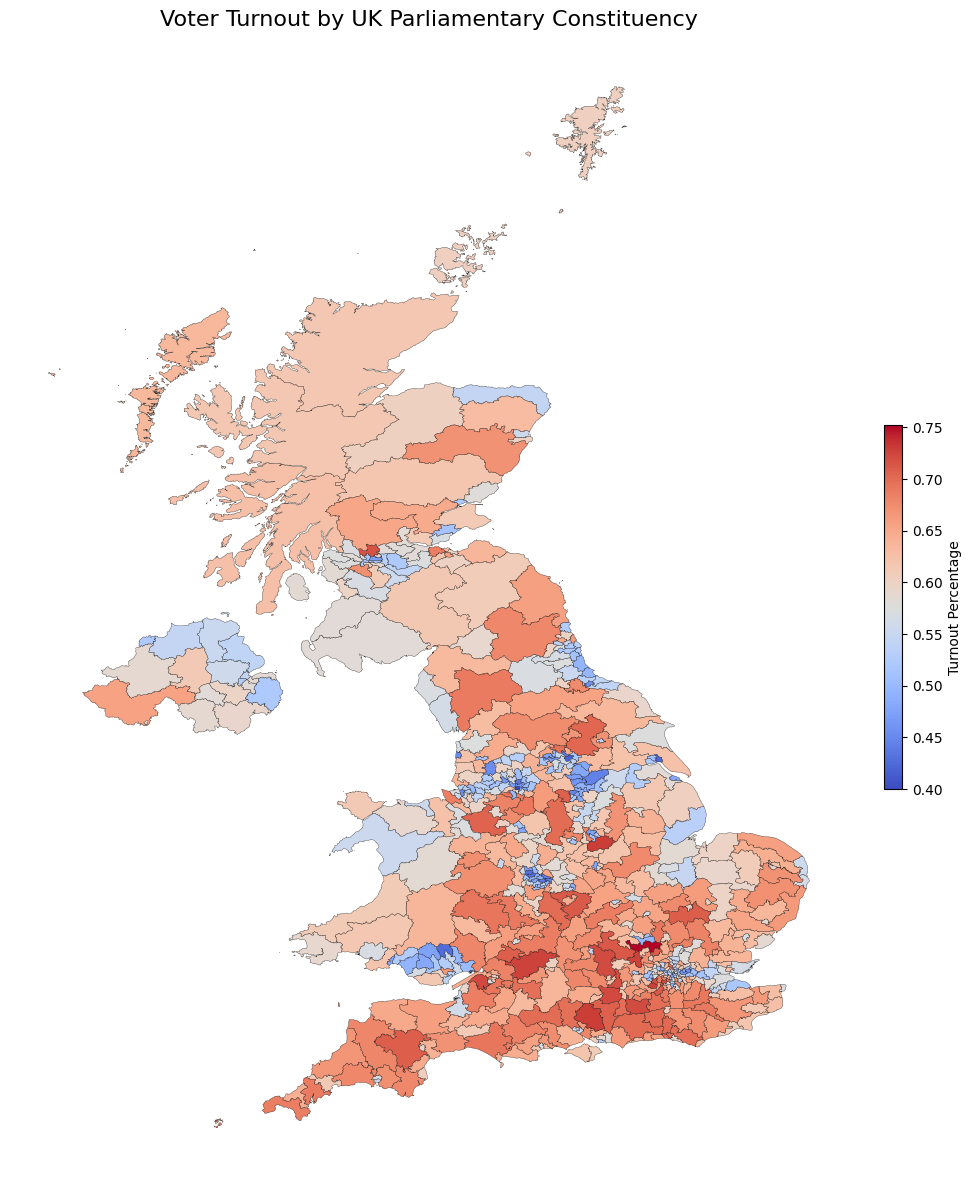

In [258]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Create a figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Define the color map and normalization based on your data
cmap = plt.cm.coolwarm
norm = mpl.colors.Normalize(
    vmin=geo_electoral_data['turnout_percentage'].min(),
    vmax=geo_electoral_data['turnout_percentage'].max()
)

# Plot without legend
geo_electoral_data.plot(
    column='turnout_percentage',
    ax=ax,
    cmap=cmap,
    edgecolor='black',
    linewidth=0.2,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing turnout"
    }
)

# Manually create a colorbar with custom size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Required for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04, shrink=0.5)
cbar.set_label('Turnout Percentage')

# Adjust aspect ratio so it looks better
ax.set_aspect(1.3)  


# Title and layout
ax.set_title("Voter Turnout by UK Parliamentary Constituency", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()


# We can also plot the color of the winning party in each constituency

In [254]:
# I just asked ChatGPT to generate a color map for the winning party in each constituency based on the party names in the electoral data.

# Define a dictionary to map party names to colors
party_colors = {
    'Labour': '#e4003b',                        # Red
    'Conservative': '#0087dc',                 # Blue
    'Liberal Democrat': '#faa61a',             # Orange/Yellow
    'Scottish National Party': '#fdf38e',      # Light Yellow
    'Green Party': '#6ab023',                  # Green
    'Plaid Cymru': '#3f8428',                  # Dark Green
    'Reform UK': '#12b6cf',                    # Teal/Light Blue
    'Democratic Unionist Party': '#d46a4c',    # Burnt Red
    'Sinn Féin': '#326760',                    # Deep Teal
    'Social Democratic & Labour Party': '#007B5E',  # Greenish
    'Alliance': '#f6cb2f',                     # Bright Yellow
    'Traditional Unionist Voice': '#3F3F3F',   # Dark Gray
    'Ulster Unionist Party': '#4fafd7',        # Light Blue
    'Independent': '#aaaaaa'                   # Gray (neutral)
}
# Map colors to a new column
geo_electoral_data['winning_party_color'] = geo_electoral_data['winningParty.name'].map(party_colors)

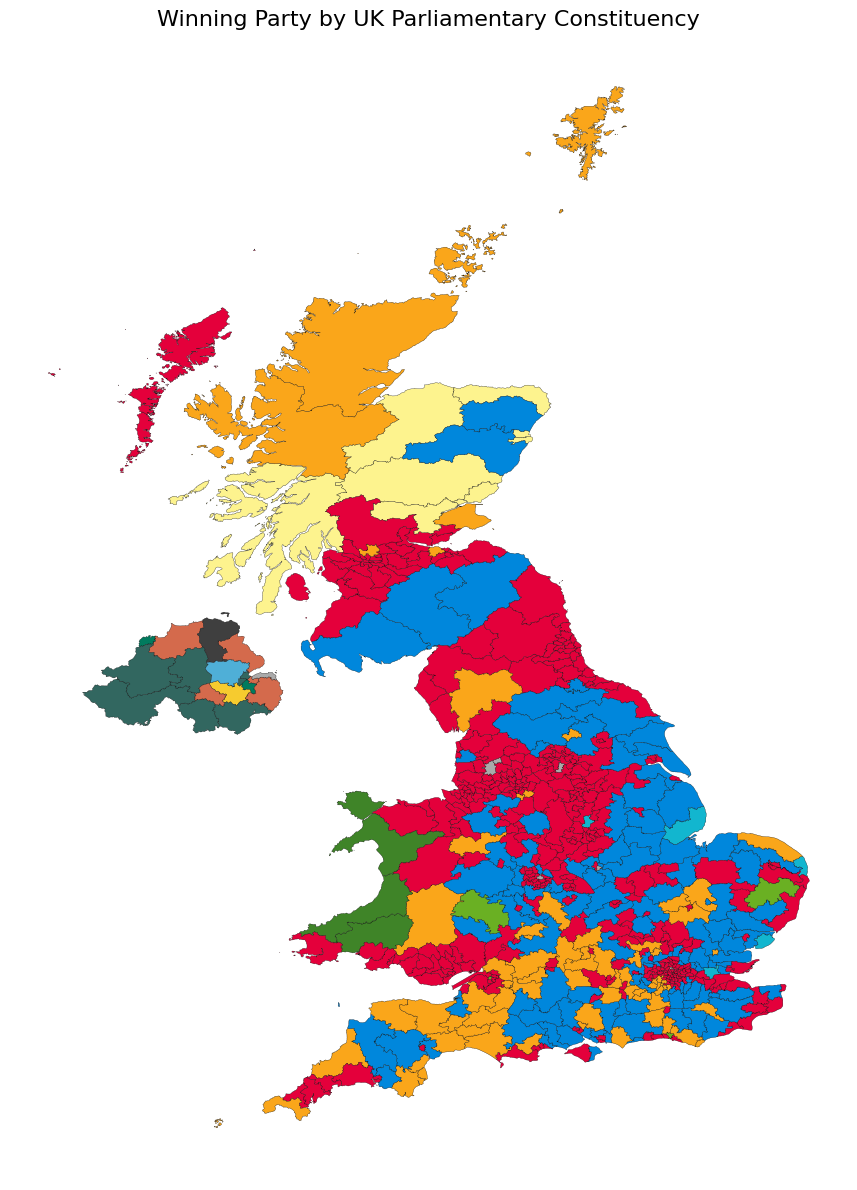

In [256]:
# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Plot using each party's color directly
geo_electoral_data.plot(
    ax=ax,
    color=geo_electoral_data['winning_party_color'],
    edgecolor='black',
    linewidth=0.2,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing data"
    }
)

# Add title and tidy up
ax.set_title("Winning Party by UK Parliamentary Constituency", fontsize=16)
ax.axis('off')


# Adjust aspect ratio so it looks better
ax.set_aspect(1.3)  

plt.tight_layout()
plt.show()

# Safest constituencies (e.g. largest majorities) 


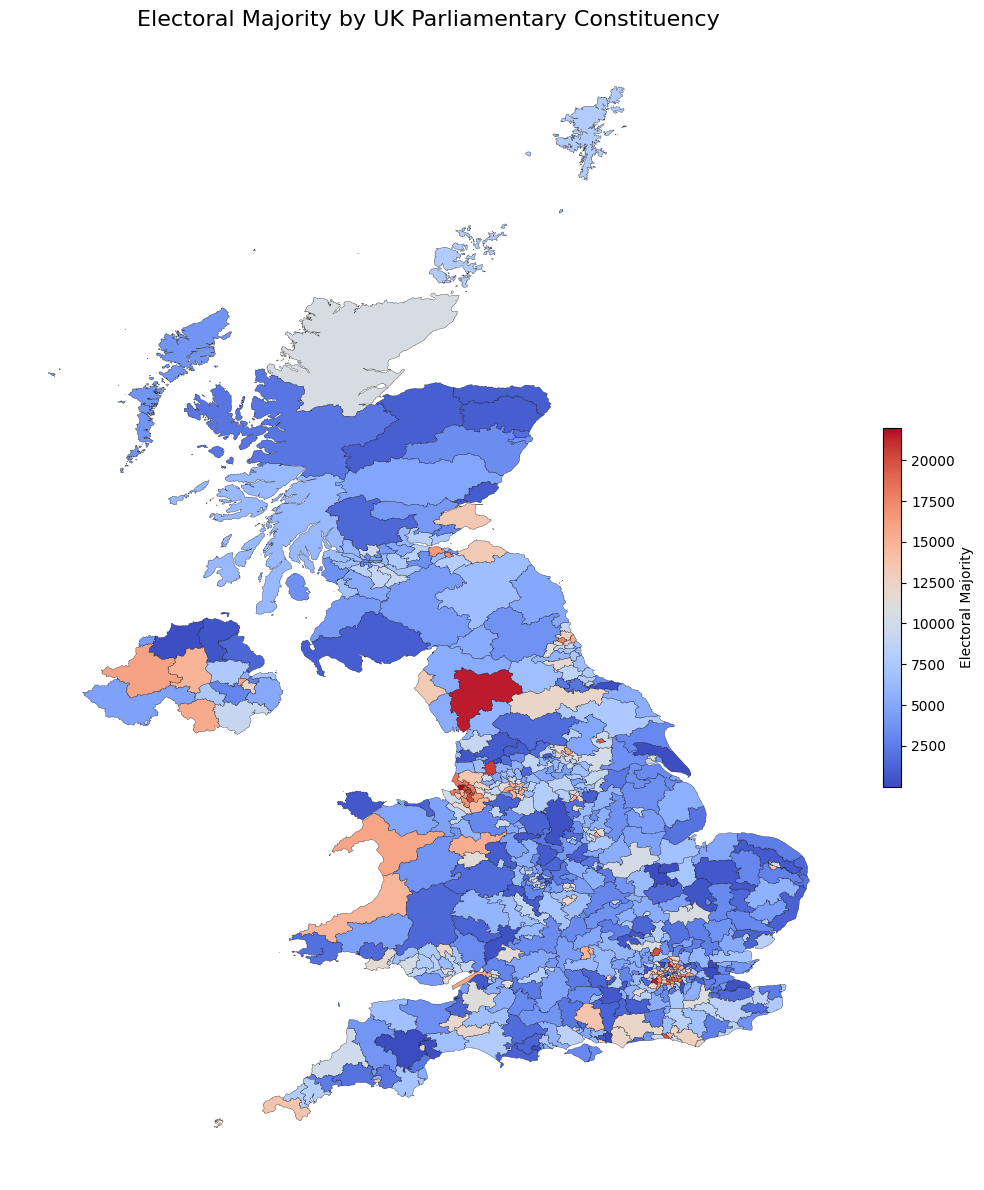

In [259]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Create a figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Define the color map and normalization based on your data
cmap = plt.cm.coolwarm
norm = mpl.colors.Normalize(
    vmin=geo_electoral_data['majority'].min(),
    vmax=geo_electoral_data['majority'].max()
)

# Plot without legend
geo_electoral_data.plot(
    column='majority',
    ax=ax,
    cmap=cmap,
    edgecolor='black',
    linewidth=0.2,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing"
    }
)

# Manually create a colorbar with custom size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Required for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04, shrink=0.5)
cbar.set_label('Electoral Majority')

# Adjust aspect ratio so it looks better
ax.set_aspect(1.3)  


# Title and layout
ax.set_title("Electoral Majority by UK Parliamentary Constituency", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()